In [76]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Coded_Segments.csv")
print(df.head())

               Dokumentname         Code  Anfang  Ende  \
0  reflection_assignment_P1      Level 1       1     1   
1  reflection_assignment_P1      Level 1       1     1   
2  reflection_assignment_P1      Level 1       1     1   
3  reflection_assignment_P1  Level 2 (a)       1     1   
4  reflection_assignment_P1  Level 2 (a)       1     1   

                                             Segment  
0  I am a newbie in data science (DS). On the one...  
1  However, the handling of data in basic cogniti...  
2  The HCDS course was largely aimed at a critica...  
3  Among these topics, some messages particularly...  
4  First of all, I became aware of the importance...  


In [3]:
df['Code'].value_counts()

Code
Level 3        90
Level 1        69
Level 2 (b)    41
Level 2 (a)    31
Level 4         6
Name: count, dtype: int64

(array([69.,  0., 31.,  0.,  0., 41.,  0., 90.,  0.,  6.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

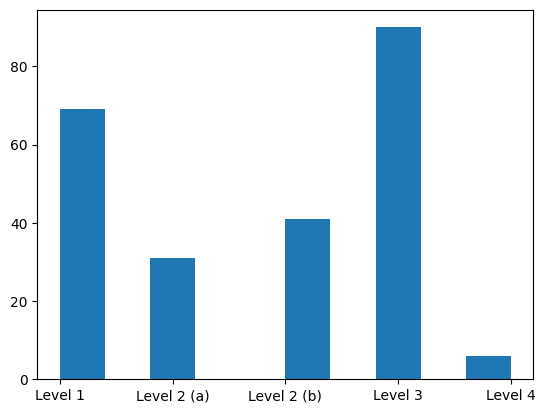

In [4]:
plt.hist(sorted(df['Code']))

In [5]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    ordinal_mapping = ['Level 1', 'Level 2 (a)', 'Level 2 (b)', 'Level 3', 'Level 4']  # Ensure correct order
    oe = OrdinalEncoder(categories=[ordinal_mapping]) # Define order
    df['class'] = oe.fit_transform(df[['Code']]).astype(int).flatten()

    # handle imbalanced dataset
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(df[['Segment']], df['class'])
    df_resampled = pd.DataFrame({'Segment': X_resampled['Segment'], 'class': y_resampled})

    print(f"Original dataset shape: {df.shape}")
    print(f"Resampled dataset shape: {df_resampled.shape}")

    return df_resampled, oe

In [6]:
df_resampled, ordinal_encoder = preprocess_data(df)
print(df_resampled)

Original dataset shape: (237, 6)
Resampled dataset shape: (450, 2)
                                               Segment  class
0    I am a newbie in data science (DS). On the one...      0
1    However, the handling of data in basic cogniti...      0
2    The HCDS course was largely aimed at a critica...      0
3    Among these topics, some messages particularly...      1
4    First of all, I became aware of the importance...      1
..                                                 ...    ...
445  The first concern, to begin  with, is to check...      4
446  The first concern, to begin  with, is to check...      4
447  Social nuances have shown how important it is ...      4
448  It also made me realise the high personal resp...      4
449  As an when my experience grew, I started to un...      4

[450 rows x 2 columns]


In [7]:
df_resampled['class'].value_counts()

class
0    90
1    90
4    90
2    90
3    90
Name: count, dtype: int64

(array([90.,  0., 90.,  0.,  0., 90.,  0., 90.,  0., 90.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

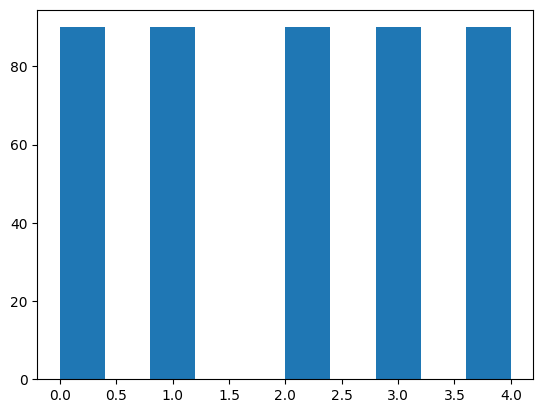

In [8]:
plt.hist(sorted(df_resampled['class']))

In [22]:
# Preprocessing
# Split into training, validation and test sets
train_df, temp_df = train_test_split(df_resampled, test_size=0.3, stratify=df_resampled['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

# Extract text and labels
X_train, y_train = train_df['Segment'], train_df['class']
X_val, y_val = val_df['Segment'], val_df['class']
X_test, y_test = test_df['Segment'], test_df['class']

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

Validation Set Results:
Accuracy: 0.63
Cohen's Kappa: 0.53
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.15      0.27        13
           1       0.52      0.93      0.67        14
           2       0.50      1.00      0.67        13
           3       0.00      0.00      0.00        13
           4       1.00      1.00      1.00        14

    accuracy                           0.63        67
   macro avg       0.60      0.62      0.52        67
weighted avg       0.61      0.63      0.53        67



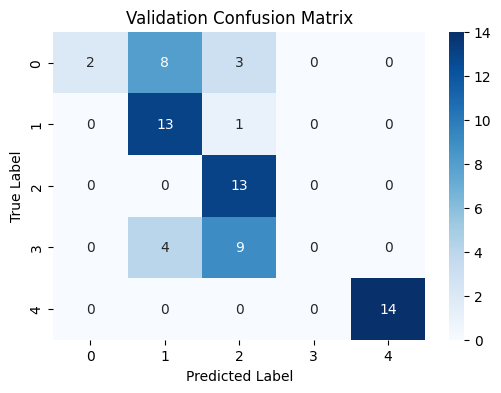

In [10]:
# Train SVM Ordinal Regression (SVR with linear kernel)
ordinal_svm = SVR(kernel="linear")
ordinal_svm.fit(X_train_tfidf, y_train)

# Predictions (round to nearest class)
ordsvm_y_val_pred = ordinal_svm.predict(X_val_tfidf).round().astype(int)
# ordsvm_y_test_pred = ordinal_svm.predict(X_test_tfidf).round().astype(int)

# Ensure predictions are within class range
ordsvm_y_val_pred = np.clip(ordsvm_y_val_pred, np.min(y_train), np.max(y_train))
# ordsvm_y_test_pred = np.clip(ordsvm_y_test_pred, np.min(y_train), np.max(y_train))

# Evaludation metrics for validation set
ordsvm_val_accuracy = accuracy_score(y_val, ordsvm_y_val_pred)
ordsvm_val_class_report = classification_report(y_val, ordsvm_y_val_pred, zero_division=0)
ordsvm_val_cohen_kappa = cohen_kappa_score(y_val, ordsvm_y_val_pred)
ordsvm_val_cm = confusion_matrix(y_val, ordsvm_y_val_pred)

# Evaludation metrics for test set
# ordsvm_test_accuracy = accuracy_score(y_test, ordsvm_y_test_pred)
# ordsvm_test_class_report = classification_report(y_test, ordsvm_y_test_pred, zero_division=0)
# ordsvm_test_cohen_kappa = cohen_kappa_score(y_test, ordsvm_y_test_pred)
# ordsvm_test_cm = confusion_matrix(y_test, ordsvm_y_test_pred)

# Print results
print("Validation Set Results:")
print(f"Accuracy: {ordsvm_val_accuracy:.2f}")
print(f"Cohen's Kappa: {ordsvm_val_cohen_kappa:.2f}")
print("Classification Report:")
print(ordsvm_val_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(ordsvm_val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_val)), yticklabels=sorted(set(y_val)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

# print("\nTest Set Results:")
# print(f"Accuracy: {ordsvm_test_accuracy:.2f}")
# print(f"Cohen's Kappa: {ordsvm_test_cohen_kappa:.2f}")
# print("Classification Report:")
# print(ordsvm_test_class_report)
# plt.figure(figsize=(6,4))
# sns.heatmap(ordsvm_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Test Confusion Matrix")
# plt.show()

Validation Set Results:
Accuracy: 0.69
Cohen's Kappa: 0.61
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.54      0.70        13
           1       0.62      0.93      0.74        14
           2       0.48      0.92      0.63        13
           3       0.00      0.00      0.00        13
           4       1.00      1.00      1.00        14

    accuracy                           0.69        67
   macro avg       0.62      0.68      0.61        67
weighted avg       0.63      0.69      0.62        67



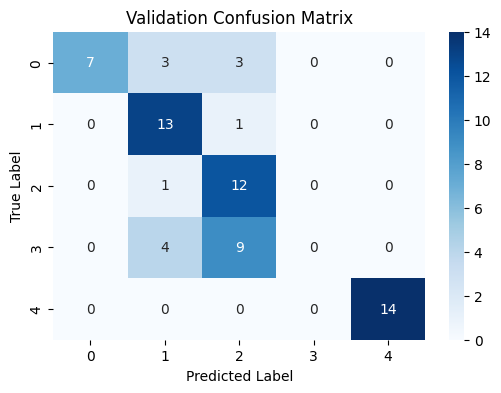

In [11]:
# Get unique ordinal levels
unique_classes = sorted(y_train.unique())
thresholds = unique_classes[:-1]  # Exclude last class (no threshold needed)
num_classes = len(unique_classes)
num_classes

# Train multiple SVM models (Pairwise constraints)
svm_models = []
for threshold in thresholds:
    binary_labels = (y_train > threshold).astype(int)  # "Is class >= k?"
    svm = SVC(kernel='linear', probability=True, random_state=42)
    svm.fit(X_train_tfidf, binary_labels)
    svm_models.append(svm)

# Prediction function
def ordinal_svm_predict(models, X):
    prob_matrix = np.zeros((X.shape[0], len(models)))
    
    for i, model in enumerate(models):
        prob_matrix[:, i] = model.predict_proba(X)[:, 1]  # Prob of class ≥ k
    
    predictions = prob_matrix.sum(axis=1)  # Count how many thresholds are exceeded
    return np.clip(predictions.round().astype(int), 0, num_classes - 1)  # Ensure within valid range

# Predictions
pcsvm_y_val_pred = ordinal_svm_predict(svm_models, X_val_tfidf)
# pcsvm_y_test_pred = ordinal_svm_predict(svm_models, X_test_tfidf)

# Evaludation metrics for validation set
pcsvm_val_accuracy = accuracy_score(y_val, pcsvm_y_val_pred)
pcsvm_val_class_report = classification_report(y_val, pcsvm_y_val_pred, zero_division=0)
pcsvm_val_cohen_kappa = cohen_kappa_score(y_val, pcsvm_y_val_pred)
pcsvm_val_cm = confusion_matrix(y_val, pcsvm_y_val_pred)

# Evaludation metrics for test set
# pcsvm_test_accuracy = accuracy_score(y_test, pcsvm_y_test_pred)
# pcsvm_test_class_report = classification_report(y_test, pcsvm_y_test_pred, zero_division=0)
# pcsvm_test_cohen_kappa = cohen_kappa_score(y_test, pcsvm_y_test_pred)
# pcsvm_test_cm = confusion_matrix(y_test, pcsvm_y_test_pred)

# Print results
print("Validation Set Results:")
print(f"Accuracy: {pcsvm_val_accuracy:.2f}")
print(f"Cohen's Kappa: {pcsvm_val_cohen_kappa:.2f}")
print("Classification Report:")
print(pcsvm_val_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(pcsvm_val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_val)), yticklabels=sorted(set(y_val)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

# print("\nTest Set Results:")
# print(f"Accuracy: {pcsvm_test_accuracy:.2f}")
# print(f"Cohen's Kappa: {pcsvm_test_cohen_kappa:.2f}")
# print("Classification Report:")
# print(pcsvm_test_class_report)
# plt.figure(figsize=(6,4))
# sns.heatmap(pcsvm_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Test Confusion Matrix")
# plt.show()

Validation Set Results:
Accuracy: 0.81
Cohen's Kappa: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.92      0.69        13
           1       0.87      0.93      0.90        14
           2       1.00      0.85      0.92        13
           3       0.80      0.31      0.44        13
           4       1.00      1.00      1.00        14

    accuracy                           0.81        67
   macro avg       0.84      0.80      0.79        67
weighted avg       0.85      0.81      0.79        67



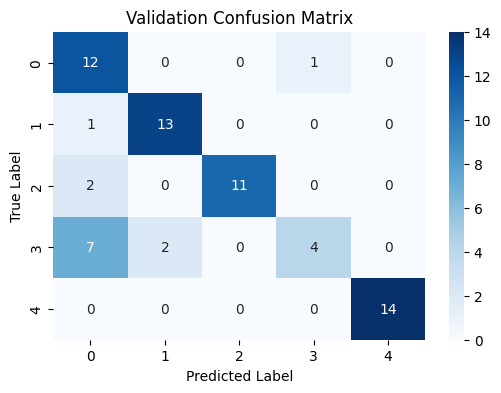

In [12]:
# Train a Random Forest model (as an approximation of Ordinal Forest)
ord_forest = RandomForestClassifier(n_estimators=100, random_state=42)
ord_forest.fit(X_train_tfidf, y_train)

# Predictions
of_y_val_pred = ord_forest.predict(X_val_tfidf)
# of_y_test_pred = ord_forest.predict(X_test_tfidf)

# Metrics for validation set
of_val_accuracy = accuracy_score(y_val, of_y_val_pred)
of_val_class_report = classification_report(y_val, of_y_val_pred, zero_division=0)
of_val_cohen_kappa = cohen_kappa_score(y_val, of_y_val_pred)
of_val_cm = confusion_matrix(y_val, of_y_val_pred)

# Metrics for test set
# of_test_accuracy = accuracy_score(y_test, of_y_test_pred)
# of_test_class_report = classification_report(y_test, of_y_test_pred, zero_division=0)
# of_test_cohen_kappa = cohen_kappa_score(y_test, of_y_test_pred)
# of_test_cm = confusion_matrix(y_test, of_y_test_pred)

# Print results
print("Validation Set Results:")
print(f"Accuracy: {of_val_accuracy:.2f}")
print(f"Cohen's Kappa: {of_val_cohen_kappa:.2f}")
print("Classification Report:")
print(of_val_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(of_val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_val)), yticklabels=sorted(set(y_val)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

# print("\nTest Set Results:")
# print(f"Accuracy: {of_test_accuracy:.2f}")
# print(f"Cohen's Kappa: {of_test_cohen_kappa:.2f}")
# print("Classification Report:")
# print(of_test_class_report)
# plt.figure(figsize=(6,4))
# sns.heatmap(of_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Test Confusion Matrix")
# plt.show()